In [ ]:
import torch, torchvision, os,PIL,pdb
from torch.utils.data import DataLoader,Dataset
from torch import nn
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def show(tensor,number=25):
  data = tensor.detach().cpu()
  grid = make_grid(data[:number],nrow = 5).permute(1,2,0)
  plt.axis('off')
  plt.imshow(grid.clip(0,1))
  plt.show()


In [ ]:
epochs = 10000
batch_size = 128
lr = .00001
z_dim = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cycle = 5
crit_losses = []
gen_losses = []
show_steps = 35
save_steps = 35

def gen_noise(num,z_dim,device = 'cuda'):
  return torch.randn(num,z_dim,device=device)

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim = 200,d_dim = 16):
    super(Generator,self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(z_dim,d_dim*32,4,1,0),
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32,d_dim*16,4,2,1),
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*16,d_dim*8,4,2,1),
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*8,d_dim*4,4,2,1),
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*4,d_dim*2,4,2,1),
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*2,3,4,2,1),
        nn.Tanh()
        )

  def forward(self,noise):
    x = noise.view(len(noise),self.z_dim,1,1)
    return self.gen(x)

In [ ]:
class critic(nn.Module):
  def __init__(self,d_dim = 16):
    super(critic,self).__init__()
    self.crit = nn.Sequential(
        nn.Conv2d(3,d_dim,4,2,1),
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(.2),

        nn.Conv2d(d_dim,d_dim*2,4,2,1),
        nn.InstanceNorm2d(2*d_dim),
        nn.LeakyReLU(.2),

        nn.Conv2d(2*d_dim,d_dim*4,4,2,1),
        nn.InstanceNorm2d(4*d_dim),
        nn.LeakyReLU(.2),

        nn.Conv2d(4*d_dim,d_dim*8,4,2,1),
        nn.InstanceNorm2d(8*d_dim),
        nn.LeakyReLU(.2),

        nn.Conv2d(8*d_dim,d_dim*16,4,2,1),
        nn.InstanceNorm2d(16*d_dim),
        nn.LeakyReLU(.2),

        nn.Conv2d(16*d_dim,1,4,1,0),
    )

  def forward(self,image):
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred),-1) ## 128 x 1

In [ ]:
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight,0.0,0.02)
    torch.nn.init.constant_(m.bias,0.0)

  if isinstance(m,nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight,0.0,0.02)
    torch.nn.init.constant_(m.bias,0.0)

In [ ]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("DrishtiSharma/Anime-Face-Dataset",split = 'train')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/63565 [00:00<?, ? examples/s]

In [ ]:
from torchvision import transforms
def custom_collate(batch):
    # Convert PIL images to tensors using torchvision.transforms
    images = [item['image'] for item in batch]
    # Resize images to a consistent size of 64x64
    transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
    ])
    # Apply the transformations to each image
    data = [transform(img) for img in images]
    return data




In [ ]:
class AnimeDataset(Dataset):
  def __init__(self,dataset):
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate, shuffle=True)
    self.dataset = torch.stack(next(iter(dataloader)))

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,idx):
    return self.dataset[idx]

  def random_image(self):
    random_idx = torch.randint(0,len(self.dataset),(1,)).item()
    plt.imshow(self.dataset[random_idx].permute(1,2,0).clip(0,1))
    plt.axis('off')
    plt.show()

In [ ]:
ds = AnimeDataset(dataset)

In [ ]:
len(ds)

128

In [ ]:
ds[5]

tensor([[[1.0000, 0.8863, 0.7686,  ..., 1.0000, 0.9882, 0.9725],
         [0.9961, 0.9490, 0.8471,  ..., 0.8745, 0.9373, 0.9882],
         [0.9961, 0.9961, 0.9216,  ..., 0.6784, 0.8275, 0.9843],
         ...,
         [0.9412, 0.9725, 0.9961,  ..., 0.7451, 0.7451, 0.7412],
         [0.9451, 0.9451, 0.9569,  ..., 0.7451, 0.7451, 0.7412],
         [0.9647, 0.9137, 0.9059,  ..., 0.7490, 0.7490, 0.7412]],

        [[0.9922, 0.8118, 0.5765,  ..., 0.9804, 0.9804, 0.9647],
         [0.9804, 0.8863, 0.6784,  ..., 0.7804, 0.8824, 0.9608],
         [0.9765, 0.9490, 0.7804,  ..., 0.4706, 0.6706, 0.8706],
         ...,
         [0.7725, 0.8275, 0.8902,  ..., 0.4039, 0.4039, 0.4000],
         [0.7490, 0.7686, 0.8275,  ..., 0.4039, 0.4039, 0.4000],
         [0.7569, 0.7294, 0.7608,  ..., 0.4039, 0.4039, 0.3961]],

        [[0.9961, 0.8235, 0.6078,  ..., 0.8745, 0.8471, 0.8118],
         [0.9922, 0.9020, 0.7059,  ..., 0.7059, 0.7804, 0.8471],
         [0.9922, 0.9686, 0.8078,  ..., 0.4549, 0.6314, 0.

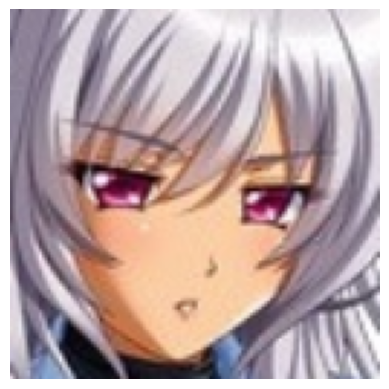

In [ ]:
ds.random_image()

In [ ]:
gen = Generator(z_dim).to(device)
crit = critic().to(device)
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate, shuffle=True)

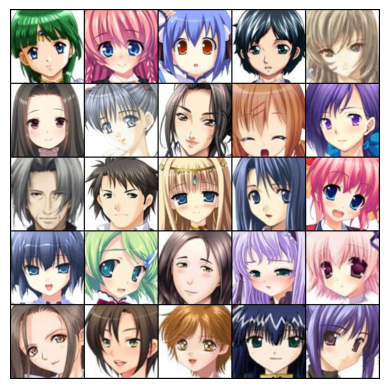

In [ ]:
show(torch.stack(next(iter(dataloader))),25)

In [ ]:
gen_opt = torch.optim.Adam(gen.parameters(),lr = lr, betas = (.5,.9))
crit_opt = torch.optim.Adam(crit.parameters(),lr = lr, betas = (.5,.9))


In [ ]:
def calc_gp(real,fake,crit,alpha,gamma):
  mix_image = alpha*real + (1-alpha)*fake
  mix_scores = crit(mix_image)
  grad = torch.autograd.grad(inputs = mix_image,
                             outputs = mix_scores,
                             grad_outputs = torch.ones_like(mix_scores),
                             retain_graph = True,
                             create_graph =True)[0]
  grad = grad.view(len(grad),-1)
  grad_norm = grad.norm(2,dim = 1)
  gp = gamma*((grad_norm-1)**2).mean()
  return gp

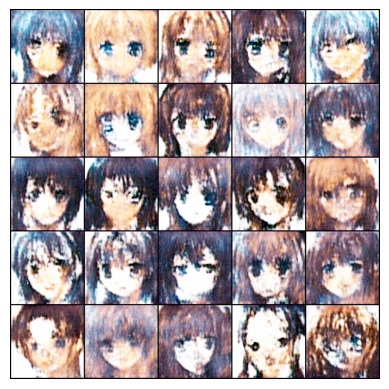

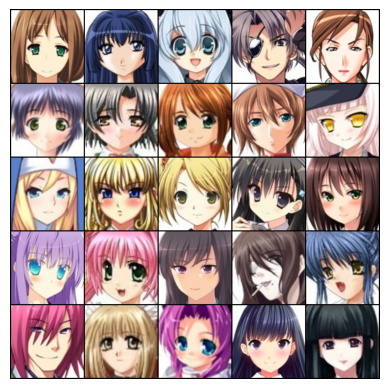

epoch:18,step: 9415, Generator loss: 24.698154994419642, Critic loss: -10.727362501961844


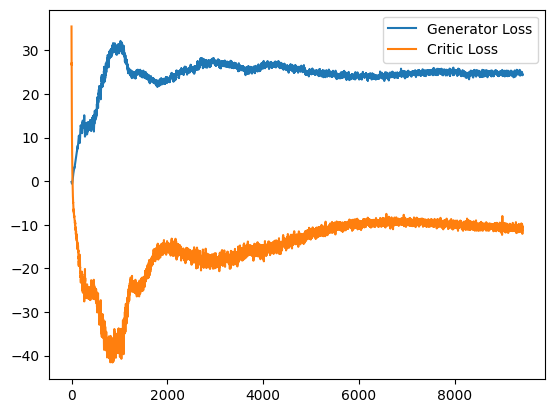

 95%|█████████▍| 470/497 [11:14<00:44,  1.65s/it]

In [ ]:
from IPython.display import clear_output
cur_step = 0
for epoch in range(epochs):
  for real in tqdm(dataloader):
    cur_bs = len(real)
    real = torch.stack(real)
    real = real.to(device)
    mean_critic_loss = 0
    for i in range(cycle):
      crit_opt.zero_grad()
      noise = gen_noise(cur_bs,z_dim)
      fake = gen(noise)
      # print(f'fake : {fake.shape}, real: {real.shape}')
      crit_real_pred = crit(real)
      crit_fake_pred = crit(fake.detach())
      alpha = torch.randn((len(real),1,1,1),device = device,requires_grad = True)
      gp = calc_gp(real,fake.detach(),crit,alpha,gamma = 10)
      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
      mean_critic_loss += crit_loss.item()/cycle
      crit_loss.backward(retain_graph = True)
      crit_opt.step()

    crit_losses += [mean_critic_loss]
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs,z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)
    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()
    gen_losses += [gen_loss.item()]

    if(cur_step% show_steps ==0 and cur_step >0):
      clear_output()
      show(fake)
      show(real)
      gen_mean = sum(gen_losses[-show_steps:])/show_steps
      crit_mean = sum(crit_losses[-show_steps:])/show_steps
      print(f"epoch:{epoch},step: {cur_step}, Generator loss: {gen_mean}, Critic loss: {crit_mean}")
      plt.plot(
               range(len(gen_losses)),
               torch.Tensor(gen_losses),
               label="Generator Loss"
               )
      plt.plot(
               range(len(crit_losses)),
               torch.Tensor(crit_losses),
               label="Critic Loss"
               )
      plt.legend()
      plt.show()

    if(cur_step% show_steps ==0 and cur_step >0):
      generator_name = f'Face_Gen_global_step_{cur_step}'
      torch.save(gen.state_dict(),generator_name)
    cur_step+= 1




In [ ]:
# !pip install langchain
# from langchain.embeddings import OpenAIEmbeddings

In [ ]:
# embeddings = OpenAIEmbeddings()
# our_text = "Hey Buddy"
# text_embedding = embeddings.embed_query(our_text)
# text_embedding